# Accelerometer Data Analysis

## Importing libraries - Sensormotion

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sensormotion

In [3]:
!{sys.executable} -m pip install numpy

In [4]:
!{sys.executable} -m pip install ipywidgets>=7.2

zsh:1: 7.2 not found


In [5]:
import pandas as pd
import numpy as np
import matplotlib
import random
%matplotlib inline
import csv

import matplotlib.pyplot as plt
import math
import sys
import pylab
import numpy.linalg 

from scipy import stats
import seaborn as sns
from IPython.display import display, Markdown

import sensormotion as sm

## Reading data and writing into a Pandas Dataframe

In [7]:
#Importing data, reading csv files into a Pandas dataframe

accelerometer = pd.read_csv('./Drum_iphone.txt', sep=';', encoding='utf-8', skiprows=1, names=['Sample', 'X', 'Y', 'Z'], low_memory=False)


In [8]:
accelerometer

,Sample,X,Y,Z
0,0,0.000102,0.000897,0.003192
1,1,0.000593,0.000412,0.003221
2,2,-0.000205,-0.000432,0.003032
3,3,0.000152,0.002197,0.005489
4,4,-0.000855,0.000374,0.001900
...,...,...,...,...
389,389,0.011044,-0.028054,0.004193
390,390,0.009335,-0.025802,0.002241
391,391,0.007502,-0.027194,0.003248
392,392,0.009659,-0.025925,0.004851


## Plotting Raw Data

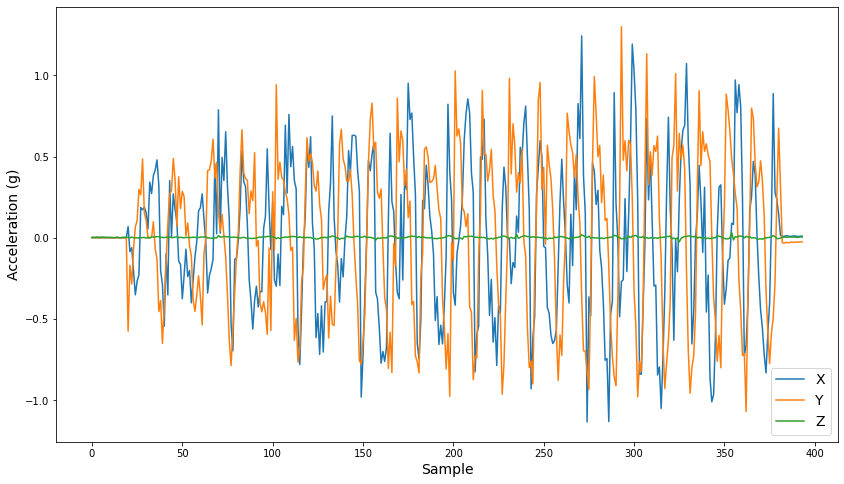

In [9]:
fig = plt.figure(figsize=(14,8))
plt.plot(accelerometer.X, label='X') #plotting acceleration in the X axis direction
plt.plot(accelerometer.Y, label='Y') #plotting acceleration in the Y axis direction
plt.plot(accelerometer.Z, label='Z') #plotting acceleration in the Z axis direction
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Acceleration (g)', fontsize=14)
plt.legend(loc='lower right', fontsize=14)


In [10]:
#Creating Time data
fs = 30 #sampling rate of the recording

time = np.linspace(0, len(accelerometer)/30, len(accelerometer))
accelerometer.insert(0, 'Time (s)', time)
accelerometer.set_index('Time (s)')
accelerometer.drop(['Sample'], axis=1, inplace=True)

(array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

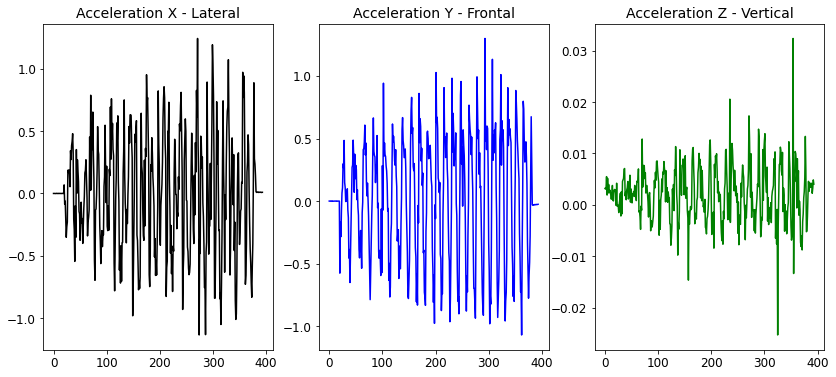

In [11]:
#Plotting acceleration in each direction separately

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 3, 1)
plt.plot(accelerometer.X, color='k') #Plotting column X
plt.title('Acceleration X - Lateral', fontsize=14) #Title of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ab = plt.subplot(1, 3, 2)
plt.plot(accelerometer.Y, color='b') #Plotting column Y
plt.title('Acceleration Y - Frontal', fontsize=14) #Title of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ac = plt.subplot(1, 3, 3)
plt.plot(accelerometer.Z, color='g') #Plotting column Z
plt.title('Acceleration Z - Vertical', fontsize=14) #Title of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Filtering Data (Cleaning noise)

First, we might want to identify the dominant frequencies in our signal to know the ideal thresholds for our filter. In reality, movement data can usually be band passed filtered at 1-10Hz, but this depends on the specific application and the axis of interest.

In [12]:
# Creating filters for human movement data frequencies

from scipy.signal import butter, lfilter
f_low = 0.5
f_high = 10

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



Text(0, 0.5, 'Acceleration (g)')

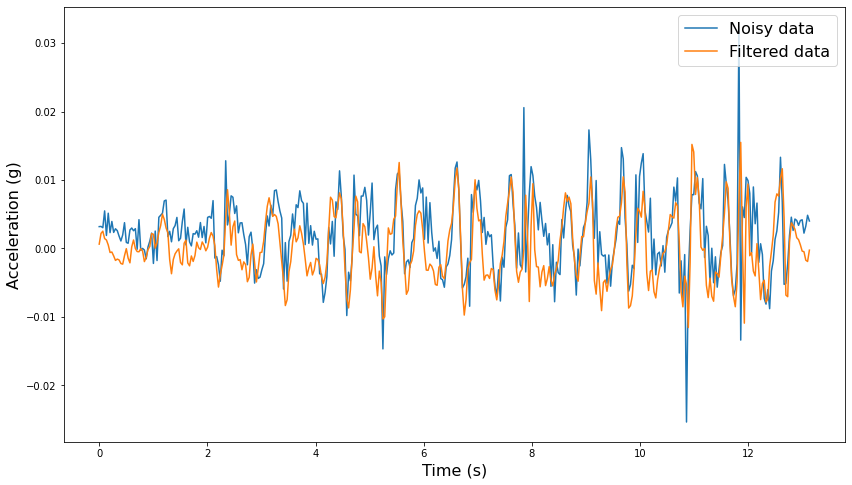

In [13]:
#Using filters on data

filtered_x = butter_bandpass_filter(accelerometer.X, f_low, f_high, fs, order=4)
filtered_y = butter_bandpass_filter(accelerometer.Y, f_low, f_high, fs, order=4)
filtered_z = butter_bandpass_filter(accelerometer.Z, f_low, f_high, fs, order=4)

#Plotting raw and filtered data in the Z direction
fig = plt.figure(figsize=(14,8))
plt.plot(time, accelerometer.Z, label='Noisy data') #Plotting column Z
plt.plot(time, filtered_z, label='Filtered data')  #Plotting filtered data on Z
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Acceleration (g)', fontsize=16)

## Physical Activity Counts

Physical activity counts are the area under the acceleration curve within a fixed-sized window (aka an epoch). Here we use the SensorMotion library. 
Typically, for long recordings we use 60-second epochs, so the signal is sliced into 60-second sections, then for each slice we calculate the PA count by integrating the signal. So, for a 10-minute period of walking, we will end up with 10 count values (1 for each minute), each representing the amount of movement over a minute.

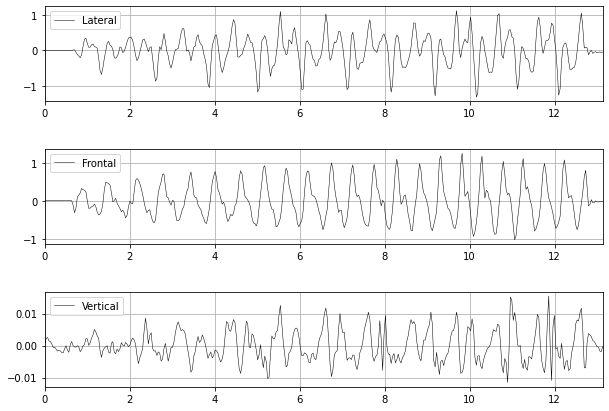

In [14]:
#Plotting filtered data using SensorMotion library

sm.plot.plot_signal(time, [{'data': filtered_x, 'label': 'Lateral', 'line_width': 0.5},
                           {'data': filtered_y, 'label': 'Frontal', 'line_width': 0.5},
                           {'data': filtered_z, 'label': 'Vertical', 'line_width': 0.5}],
                    subplots=True, fig_size=(10,7))


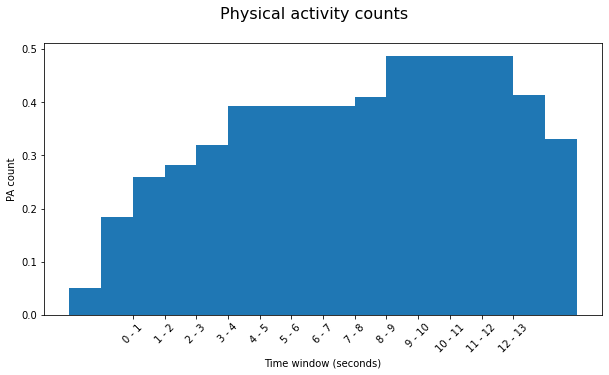

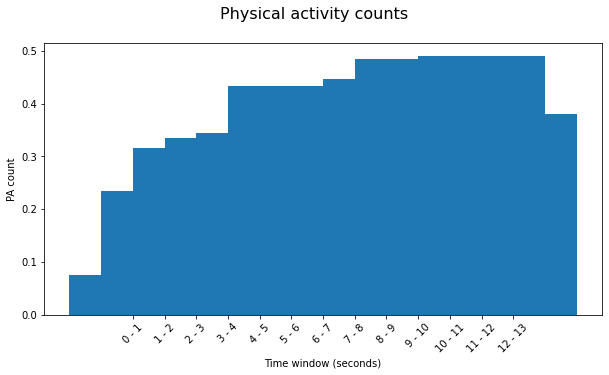

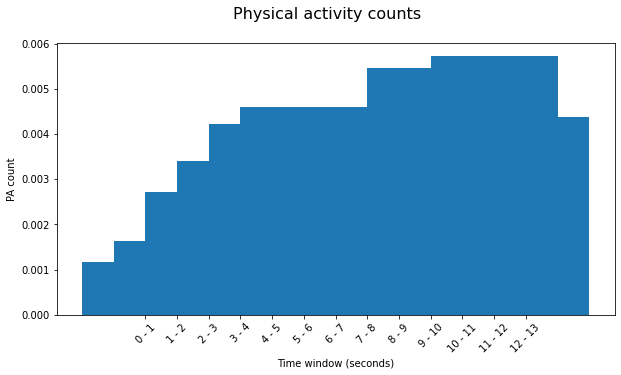

In [15]:
#Plotting Physical activity counts (physical activity events every 1s for our short example).
x_counts = sm.pa.convert_counts(filtered_x, time, time_scale='s', epoch=1, rectify='full', integrate='simpson', plot=True)
y_counts = sm.pa.convert_counts(filtered_y, time, time_scale='s', epoch=1, rectify='full', integrate='simpson', plot=True)
z_counts = sm.pa.convert_counts(filtered_z, time, time_scale='s', epoch=1, rectify='full', integrate='simpson', plot=True)

## Categorizing Physical Activity Intensity
We can now use pre-defined cut-point sets to categorize each epoch into PA intensities (e.g. sedentary, moderate, vigorous).

First we combine the data from the 3 directions and calculate the vector magnitude (VM) of counts.
Then we use thresholds from previous research on adult population.

In [16]:
#Calculating vector magnitude (vm) of counts

vm = sm.signal.vector_magnitude(x_counts, y_counts, z_counts)  

Cut-point set: freedson_adult (axis count: 3)...
light: -inf to 2690
moderate: 2691 to 6166
vigorous: 6167 to 9642
very vigorous: 9643 to inf


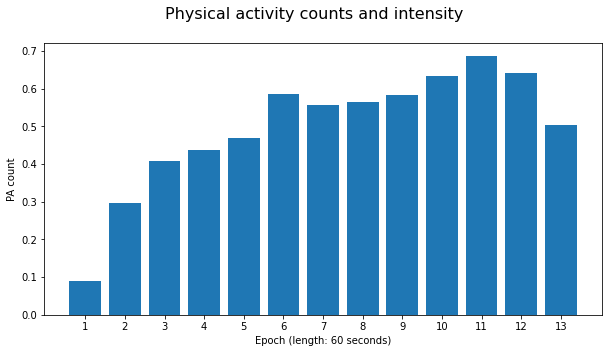

In [17]:
#Categorizing physical activity. Based on thresholds found in literature. 
#(Light, moderate, vigourous, very vigourous)
categories, time_spent = sm.pa.cut_points(vm, set_name='freedson_adult', n_axis=3, plot=True) #Here, set_name is the pre-defined threshold based on research

#returns amount of time spent on each physical activity category, requires longer data.

## Planar acceleration
How much movement occurred in a particular plane (XY, XZ, YZ) and in which directions

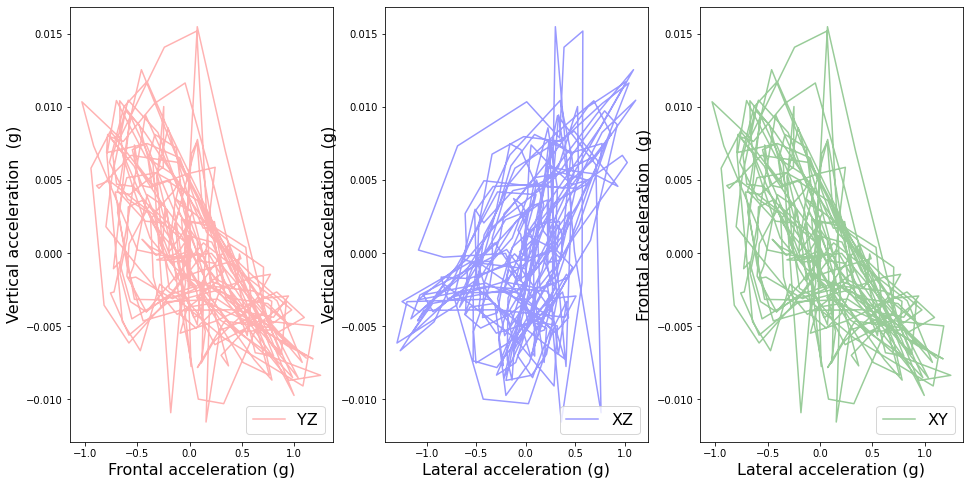

In [18]:
#Comparing acceleration on each plane


fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(1, 3, 1)
plt.plot(filtered_y, filtered_z, color='red',alpha=0.3, label='YZ') #We plot filtered acceleration in Y vs filtered acceleration in Z
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Frontal acceleration (g)',fontsize=16)
plt.ylabel('Vertical acceleration  (g)',fontsize=16)
ax1.set_facecolor("white")


ax2 = plt.subplot(1, 3, 2)
plt.plot(filtered_x, filtered_z, color='blue',alpha=0.4, label='XZ') #We plot filtered acceleration in X vs filtered acceleration in Z
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Lateral acceleration (g)',fontsize=16)
plt.ylabel('Vertical acceleration  (g)',fontsize=16)
ax2.set_facecolor("white")


ax3 = plt.subplot(1, 3, 3)
plt.plot(filtered_y, filtered_z, color='green',alpha=0.4, label='XY') #We plot filtered acceleration in X vs filtered acceleration in Y
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Lateral acceleration (g)',fontsize=16)
plt.ylabel('Frontal acceleration  (g)',fontsize=16)
ax3.set_facecolor("white")




## Rectified Acceleration (Absolute value)

In [19]:
#Rectifying accelerations - Absolute values

filtered_accx = pd.DataFrame(data=filtered_x, index=time, columns=['X'])
filtered_accy = pd.DataFrame(data=filtered_y, index=time, columns=['Y'])
filtered_accz = pd.DataFrame(data=filtered_z, index=time, columns=['Z'])

rectified_accx = filtered_accx.abs()
rectified_accy = filtered_accy.abs()
rectified_accz = filtered_accz.abs()

Text(0, 0.5, 'Acceleration (g)')

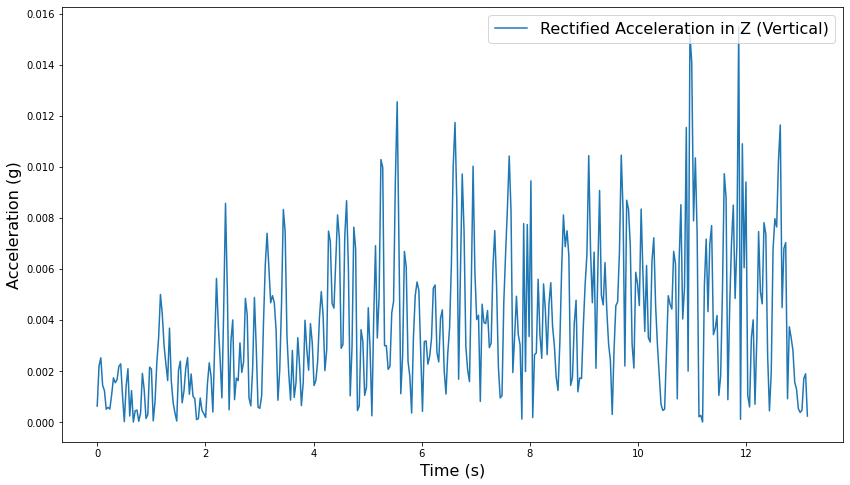

In [20]:
fig = plt.figure(figsize=(14,8))
plt.plot(rectified_accz, label='Rectified Acceleration in Z (Vertical)') #Plotting Z
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Acceleration (g)', fontsize=16)

## Cumulative Acceleration
It tells us more about the trend, points in time in which the change of acceleration was higher

Text(0.5, 1.0, 'Cumulative acceleration')

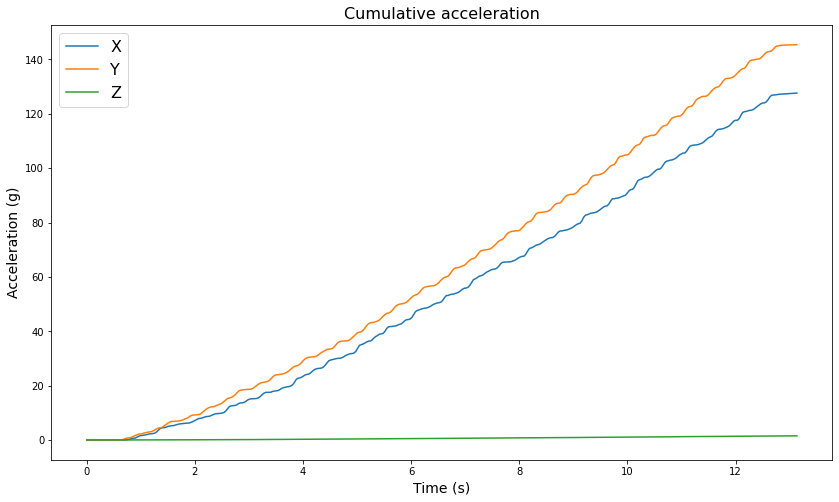

In [21]:
#Cumulative acceleration
sumacc_x = rectified_accx.cumsum()
sumacc_y = rectified_accy.cumsum()
sumacc_z = rectified_accz.cumsum()

fig = plt.figure(figsize=(14,8))
plt.plot(sumacc_x, label='X') #Plotting cumulative acc in X
plt.plot(sumacc_y, label='Y') #Plotting cumulative acc in Y
plt.plot(sumacc_z, label='Z') #Plotting cumulative acc in Z
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Acceleration (g)', fontsize=14);
plt.legend(loc='upper left', fontsize=16)
plt.title('Cumulative acceleration', fontsize=16)




## Calculating Velocity and Position from acceleration

As we saw earlier, acceleration is the rate of change of velocity, and velocity is the rate of change of position. 

We can calculate velocity by integrating the acceleration.

We can calculate position by integrating the velocity.

In [22]:
from scipy import integrate

In [23]:
#First we need to convert accelerometer data from g to SI units (m/s^2). 1 g-unit is equal to 9.80665 meter/square second.
filtered_x_si = filtered_x*9.80665
filtered_y_si = filtered_y*9.80665
filtered_z_si = filtered_z*9.80665

In [24]:
#Integrating filtered acceleration to get velocity in each direction

velocity_x = integrate.cumtrapz(filtered_x_si, time, initial=0)
velocity_y = integrate.cumtrapz(filtered_y_si, time, initial=0)
velocity_z = integrate.cumtrapz(filtered_z_si, time, initial=0)

(array([-0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

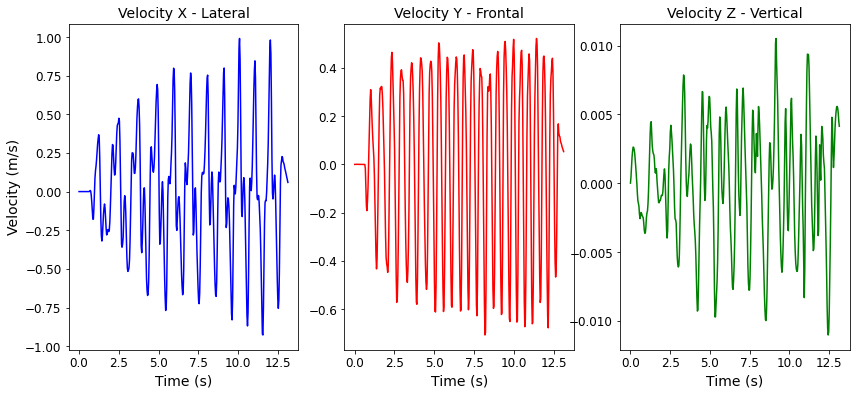

In [25]:
#Plotting velocities in each direction


fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 3, 1)
plt.plot(time, velocity_x, color='b') #Plotting  X
plt.title('Velocity X - Lateral', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Velocity (m/s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ab = plt.subplot(1, 3, 2)
plt.plot(time, velocity_y, color='r') #Plotting  Y
plt.title('Velocity Y - Frontal', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ac = plt.subplot(1, 3, 3)
plt.plot(time, velocity_z, color='g') #Plotting  Z
plt.title('Velocity Z - Vertical', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [26]:
#Integrating velocity to get position in each direction

position_x = integrate.cumtrapz(velocity_x, time, initial=0)
position_y = integrate.cumtrapz(velocity_y, time, initial=0)
position_z = integrate.cumtrapz(velocity_z, time, initial=0)

(array([-0.0035, -0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,
         0.    ,  0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

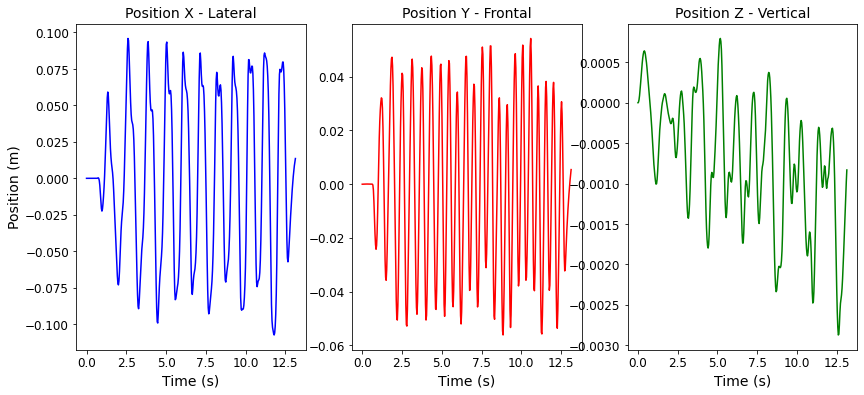

In [27]:
#Plotting position in each direction

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 3, 1)
plt.plot(time, position_x, color='b') #Plotting  X
plt.title('Position X - Lateral', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Position (m)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ab = plt.subplot(1, 3, 2)
plt.plot(time, position_y, color='r') #Plotting  Y
plt.title('Position Y - Frontal', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ac = plt.subplot(1, 3, 3)
plt.plot(time, position_z, color='g') #Plotting  Z
plt.title('Position Z - Vertical', fontsize=14) #Title of the plot
plt.xlabel('Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

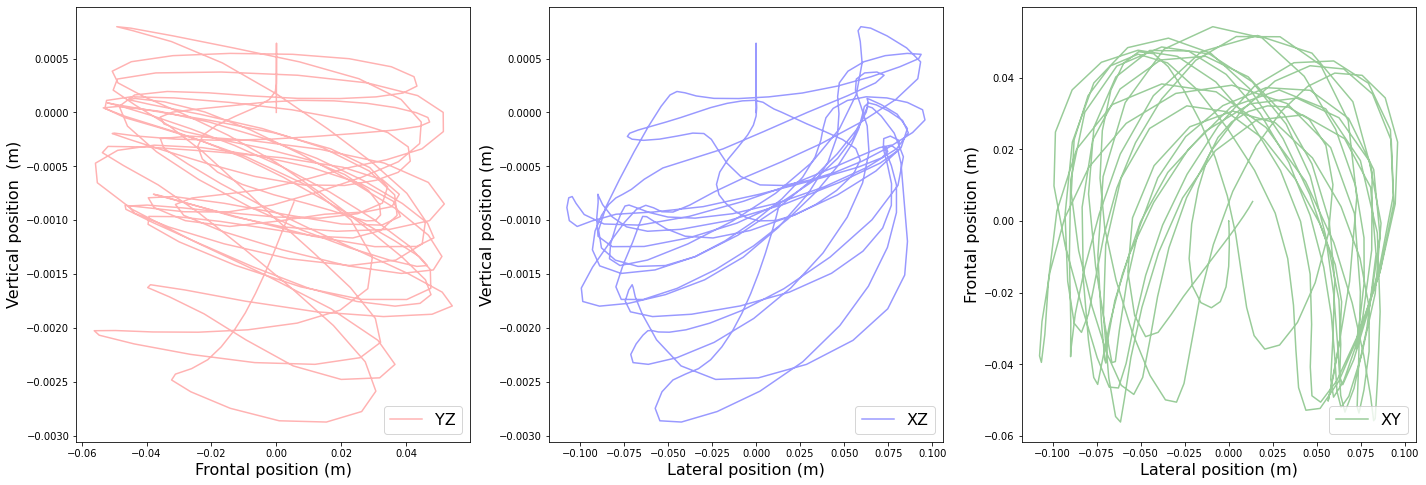

In [28]:
#Looking at position on each plane


fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(1, 3, 1)
plt.plot(position_y, position_z, color='red',alpha=0.3, label='YZ') #We plot position in Y vs position in Z
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Frontal position (m)',fontsize=16)
plt.ylabel('Vertical position  (m)',fontsize=16)
ax1.set_facecolor("white")


ax2 = plt.subplot(1, 3, 2)
plt.plot(position_x, position_z, color='blue',alpha=0.4, label='XZ') #We plot position in X vs position in Z
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Lateral position (m)',fontsize=16)
plt.ylabel('Vertical position (m)',fontsize=16)
ax2.set_facecolor("white")


ax3 = plt.subplot(1, 3, 3)
plt.plot(position_x, position_y, color='green',alpha=0.4, label='XY') #We plot position in X vs position in Y
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('Lateral position (m)',fontsize=16)
plt.ylabel('Frontal position (m)',fontsize=16)
ax3.set_facecolor("white")

## Writing analysed data/results into csv

In [29]:
#Writing position data

numpy.savetxt("position_x.csv", position_x, delimiter=",")
numpy.savetxt("position_y.csv", position_y, delimiter=",")
numpy.savetxt("position_z.csv", position_z, delimiter=",")

In [ ]:
#Writing velocity data

numpy.savetxt("velocity_x.csv", velocity_x, delimiter=",")
numpy.savetxt("velocity_y.csv", velocity_y, delimiter=",")
numpy.savetxt("velocity_z.csv", velocity_z, delimiter=",")

In [ ]:
#Writing filtered acceleration data

numpy.savetxt("filteredacc_x.csv", filtered_x, delimiter=",")
numpy.savetxt("filteredacc_y.csv", filtered_y, delimiter=",")
numpy.savetxt("filteredacc_z.csv", filtered_z, delimiter=",")

In [ ]:
#Writing cumulative acceleration data

numpy.savetxt("sumacc_x.csv", sumacc_x, delimiter=",")
numpy.savetxt("sumacc_y.csv", sumacc_y, delimiter=",")
numpy.savetxt("sumacc_z.csv", sumacc_z, delimiter=",")


In [ ]:
#Writing physical activity categories and time spent data

physical_activity = pd.DataFrame(time_spent)
physical_activity.to_csv('physical_activity.csv', index=False)

In [ ]:
#Writing activity counts for each chosen epoch (we chose every 1s for this example) in each direction

numpy.savetxt("act_countx.csv", x_counts, delimiter=",")
numpy.savetxt("act_county.csv", y_counts, delimiter=",")
numpy.savetxt("act_countz.csv", z_counts, delimiter=",")